<a href="https://colab.research.google.com/github/eladavid/exampleprob/blob/master/vibro_12Apr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# File upload

In [3]:
#########     preparation block       #########
#   install mne package & upload eeg data files
###############################################
!pip install mne

from google.colab import files
uploaded = files.upload()

Saving EEG_Data_03.vhdr to EEG_Data_03.vhdr


# data initialization

In [0]:
import os
import sys
import mne
import matplotlib.pyplot as plt
import time
plt.style.use('default')
import scipy.io as sio
import numpy as np
from scipy import signal
from scipy import fft
import array as arr
from pandas import DataFrame
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [15]:



START_ARG=0
STOP_ARG=240000
NumOfChannels = 70
vhdr_file = 'EEG_Data_03.vhdr'
raw_data = mne.io.read_raw_brainvision(vhdr_file, misc='auto', scale=1000000.0)
elec_names = raw_data.ch_names
data_info = (raw_data.get_data(start=START_ARG,stop = STOP_ARG))
dataFft = fft.fft(data_info,axis = 1)
#### define important electrodes ####
key_elecs = ['Fz','FCz','Cz','CPz','Pz']
for i in range(6):
    key_elecs.append('F' + str(i+1))
    key_elecs.append('C' + str(i+1))
    key_elecs.append('CP' + str(i+1))
    key_elecs.append('P' + str(i+1))
    key_elecs.append('FC' + str(i+1))

##### filter key elec channels #####
key_inds = []
for ind,ch_name in enumerate(elec_names):
    if ch_name in key_elecs:
        key_inds.append(ind)

key_data = data_info[key_inds]

#####   data filtering block  #####
zi_notch=[]
zi_band=[]
welch_1=18
welch_2=24
idx_topo=np.array(range(64))
freq_1_y=20
freq_2_y=20
order = 2
fs = 500
lowcut = 10
highcut = 40
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
      
f0 = 50.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor
        #Design notch filter
        
b_notch, a_notch = signal.iirnotch(f0, Q, fs)
b_band, a_band = signal.butter(order, [low, high], btype='band')

#zi_notch = signal.lfilter_zi(b_notch,a_notch)
#zi_band = signal.lfilter_zi(b_band,a_band)
for i in range(np.size(key_data,0)):
  zi_notch.append(signal.lfilter_zi(b_notch, a_notch))
  zi_band.append(signal.lfilter_zi(b_band, a_band))
def Filter_data(data, a_notch,b_notch,a_band,b_band,zi_notch,zi_band):
        #  FILTERING DATA           
        # =============================================================================
       data, zi_notch = signal.lfilter(b_notch, a_notch, data, axis=1, zi=zi_notch)
       data, zi_band = signal.lfilter(b_band, a_band, data, axis=1, zi=zi_band)
       #zi_notch = zf_notch
       #zi_band = zf_band
       return data, zi_notch,zi_band

def Filter_data_filtfilt(data, a_notch,b_notch,a_band,b_band,zi_notch,zi_band):
        #  FILTERING DATA           
        # =============================================================================
       data = signal.filtfilt(b_notch, a_notch, data, axis=1)
       data = signal.filtfilt(b_band, a_band, data, axis=1)
       #zi_notch = zf_notch
       #zi_band = zf_band
       return data









Extracting parameters from EEG_Data_03.vhdr...
Setting channel info structure...


# Pre & Post filter FFT check

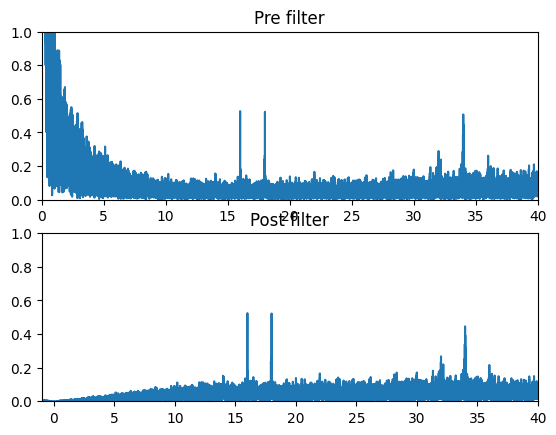

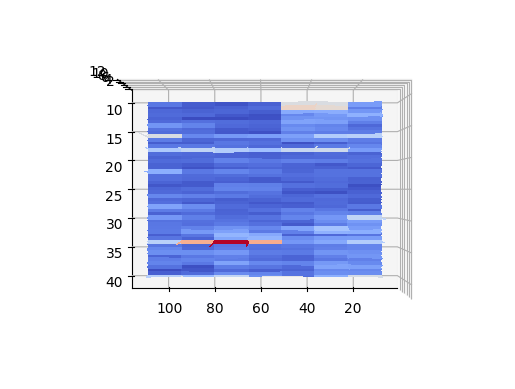

In [26]:
fig, (ax_o, ax_filt) = plt.subplots(2, 1,sharex=True)

plt.subplot(2, 1, 1)
f = fft.fftshift(fft.fft(key_data[1]))
xf = np.linspace(-fs/2, fs/2, np.size(f))
plt.plot(xf,2.0/np.size(f) * np.abs(f))
plt.title('Pre filter')
plt.xlim(left = 0, right = 40)
plt.ylim(bottom = 0, top = 1)
#plt.plot((key_data[15]));

filtered_key_data, zi_notch , zi_band = Filter_data(key_data, a_notch,b_notch,a_band,b_band,zi_notch,zi_band)
#plt.plot((filtered_key_data[15][100:]));
f_filt = fft.fftshift(x = fft.fft(filtered_key_data[1][:]))
plt.subplot(2, 1, 2)
plt.plot(xf,2.0/np.size(f_filt) * np.abs(f_filt))
plt.title('Post filter')
plt.xlim(left = -1, right = 40)
plt.ylim(bottom = 0, top = 1)
plt.show

########## Spectrogram try  ###########

fig = plt.figure()
ax = fig.gca(projection='3d')

f_1, t_1, spectro1  = signal.spectrogram(key_data[1][1000:60000],fs=fs,nperseg=8192)
f_1_crop=f_1[(f_1<=(highcut)) & (f_1>=(lowcut))]
spectro1_crop=spectro1[:][(f_1<=(highcut)) & (f_1>=(lowcut))]
X, Y = np.meshgrid(t_1, f_1_crop)
surf = ax.plot_surface(X, Y,
                          spectro1_crop,
                          cmap=cm.coolwarm,
                          linewidth=0,
                          antialiased=False)
ax.view_init(90, 90)



# Scipy Correlation check

Before filtering

<function matplotlib.pyplot.show>

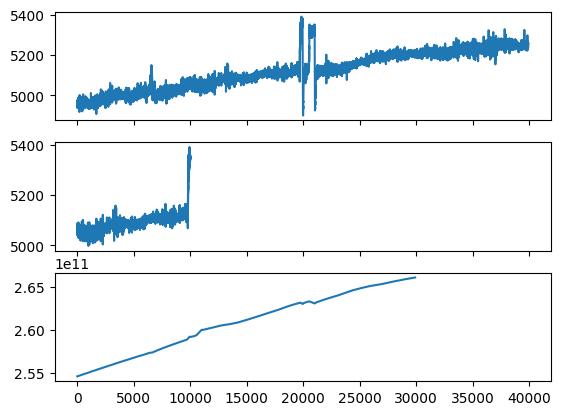

In [33]:
fig, (ax_sig, ax_kernel, ax_corr) = plt.subplots(3, 1, sharex=True)

### Correl
corr_cz = signal.correlate(key_data[1][100:40000],key_data[1][10000:20000],mode='valid')
np.size(corr_cz)
#time = np.arange(0,5000,1)

ax_sig.plot(key_data[1][100:40000])
ax_kernel.plot(key_data[1][10000:20000])
ax_corr.plot(corr_cz)
plt.show

After Filtering

<function matplotlib.pyplot.show>

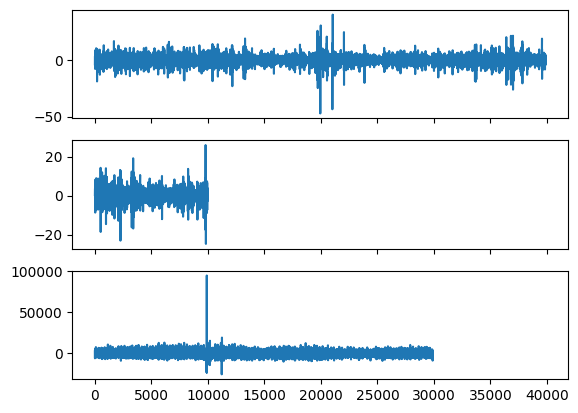

In [35]:
### Correl
corr_cz = signal.correlate(filtered_key_data[1][100:40000],filtered_key_data[1][10000:20000],mode='valid')
np.size(corr_cz)
#time = np.arange(0,5000,1)
fig, (ax_sig, ax_kernel, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_sig.plot(filtered_key_data[1][100:40000])
ax_kernel.plot(filtered_key_data[1][10000:20000])
ax_corr.plot(corr_cz)
plt.show